<img src="https://lies.mat.uc.cl/wp-content/uploads/2017/09/logo-uc-lineal-azul.png" width="300px" alt="puc logo">

<hr>
<h3 align="center"> Proyecto: Tópicos Avanzados en Inteligencia de Máquina </h3>
<h3 align="center"> Estudiantes: Fernanda Weiss - Ignacio Espinoza (18406882)</h3>
<hr>

### Objetivos:
- Para la segunda etapa
(Avances), usted deberá presentar al menos listo el pre-processamiento necesario de los datos, junto con
la implementación inicial del modelo y las primeras pruebas experimentales

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.read_csv("sleep_wake.csv")
print("-- Information of the data --")
print(data.info())
data.head()

-- Information of the data --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
Date     64 non-null object
Sleep    64 non-null int64
Wake     64 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.6+ KB
None


,Date,Sleep,Wake
0,12/1/2017,16,1
1,12/2/2017,19,-10
2,12/3/2017,-45,0
3,12/4/2017,8,1
4,12/5/2017,-23,-16


64 datos iniciales

Se calcula la hora en que la persona durmió y despertó respecto al indicador de **Sleep** and **Wake**, incluyendo esta información en las columnas **Sleep_hour** y **Wake_hour**.

In [3]:
# definir hora de dormir y despertar
data['Date'] = pd.to_datetime(data['Date'])
data['Sleep_hour'] = [d + pd.DateOffset(minutes=m, hours=22) for d, m in zip(data['Date'], data['Sleep'])]
data['Wake_hour'] = [d + pd.DateOffset(minutes=m, hours=6) for d, m in zip(data['Date'], data['Wake'])]
data.head()

,Date,Sleep,Wake,Sleep_hour,Wake_hour
0,2017-12-01,16,1,2017-12-01 22:16:00,2017-12-01 06:01:00
1,2017-12-02,19,-10,2017-12-02 22:19:00,2017-12-02 05:50:00
2,2017-12-03,-45,0,2017-12-03 21:15:00,2017-12-03 06:00:00
3,2017-12-04,8,1,2017-12-04 22:08:00,2017-12-04 06:01:00
4,2017-12-05,-23,-16,2017-12-05 21:37:00,2017-12-05 05:44:00


In [7]:
def create_data(data, first_date, last_date, night_bot, night_top, morning_bot, morning_top):
    # create sleep data
    sleep_dates = pd.date_range(first_date, last_date, freq="1min")
    sleep_dates = sleep_dates[(sleep_dates.hour >= night_bot) & (sleep_dates.hour < night_top)]
    offset = list(range(-30*(night_top-night_bot),30*(night_top-night_bot)))*63
    is_sleep = []
    
    for date in sleep_dates:
        for hour in data['Sleep_hour']:
            if date.dayofyear == hour.dayofyear:
                if date < hour:
                    is_sleep.append(0)
                else:
                    is_sleep.append(1)
    sleep_data = pd.DataFrame({'Date': sleep_dates, 'Sleep': is_sleep, 'Offset': offset})
    
    # create wake data
    wake_dates = pd.date_range(first_date, last_date, freq="1min")
    wake_dates = wake_dates[(wake_dates.hour >= morning_bot) & (wake_dates.hour < morning_top)]
    is_sleep = []

    for date in wake_dates:
        for hour in data['Wake_hour']:
            if date.dayofyear == hour.dayofyear:
                if date < hour:
                    is_sleep.append(1)
                else:
                    is_sleep.append(0)
    wake_data = pd.DataFrame({'Date': wake_dates, 'Sleep': is_sleep, 'Offset': offset})
    
    return sleep_data, wake_data

In [11]:
first_date = min(data['Date'])
last_date = max(data['Date'])
sleep1, wake1 = create_data(data, first_date, last_date, 21, 23, 5, 7)
sleep2, wake2 = create_data(data, first_date, last_date, 20, 24, 4, 8)

In [18]:
print("Observaciones dataset 1 - Datos de dormir: %d - Datos de despertar: %d " % (len(sleep1), len(wake1)))
print("Observaciones dataset 2 - Datos de dormir: %d - Datos de despertar: %d " % (len(sleep2), len(wake2)))


Observaciones dataset 1 - Datos de dormir: 7560 - Datos de despertar: 7560 
Observaciones dataset 2 - Datos de dormir: 15120 - Datos de despertar: 15120 


In [14]:
sleep1.to_csv('sleep1_data.csv')
wake1.to_csv('wake1_data.csv')
sleep2.to_csv('sleep2_data.csv')
wake2.to_csv('wake2_data.csv')

Luego del preprocesamiento cada dataset tiene las columnas **Date** (fecha y hora de la medición), **Sleep** (booleano de si la persona está durmiendo=1 o no=0) y **Offset** que mide la distancia de **Date** a la hora media de dormir y despertar.

Función logística

\\[P(t) = \frac{1}{1+e^{-\beta t}}\\]



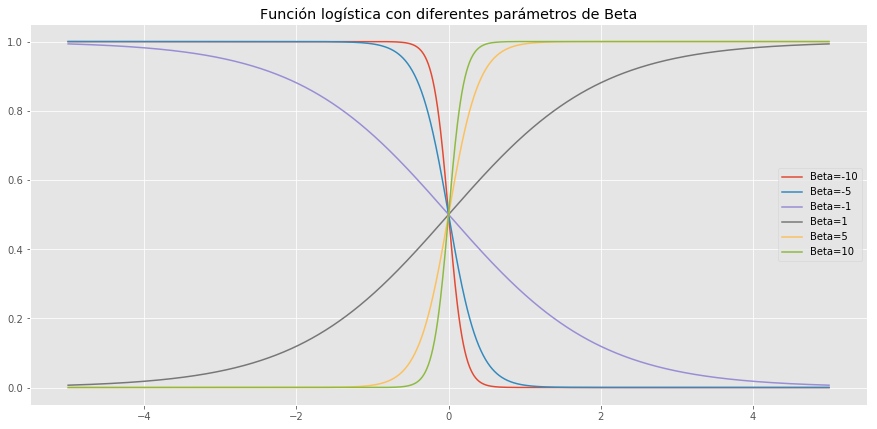

In [41]:
logistic = lambda x, beta : 1 / (1 + np.exp(-beta * x))

x = np.linspace(-5,5,1000)
beta = [-10, -5, -1, 1, 5, 10]

plt.figure(figsize=(15,7))
for b in beta:
    plt.plot(x, logistic(x, b), label="Beta="+str(b))
plt.title("Función logística con diferentes parámetros de Beta")
plt.legend()
plt.show()

Función logística 2

Como necesitamos una función que modele el problema y que no necesariamente esté centrada simétricamente en cero se utilizará la ecuación de Regresión logística, donde el término $\beta_0$ permitirá que la curva pueda moverse en el eje x.

\\[P(t) = \frac{1}{1+e^{-(\beta_0+\beta_1*t)}}\\]



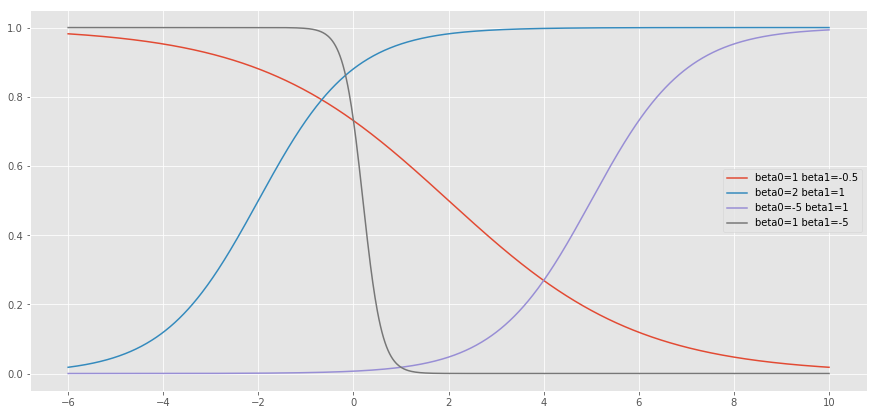

In [53]:
reg_logistic = lambda x, beta0, beta1 : 1 / (1 + np.exp(-(beta0 + beta1*x)))
x = np.linspace(-6,10,1000)
plt.figure(figsize=(15,7))
plt.plot(x, reg_logistic(x, 1, -0.5), label="beta0=1 beta1=-0.5")
plt.plot(x, reg_logistic(x, 2, 1), label="beta0=2 beta1=1")
plt.plot(x, reg_logistic(x, -5,1), label="beta0=-5 beta1=1")
plt.plot(x, reg_logistic(x, 1,-5), label="beta0=1 beta1=-5")
plt.legend()
plt.show()